In [1]:
%run ../../utils/commonImports.py
%run ../../utils/tradingImports.py
%matplotlib inline

from base import supres, BaseStrategy
from trading.walletHistory import WalletHistory
from exputils import *

# Load Data

In [2]:
# dropbox_dir = 'D:\\Dropbox\\My work\\krypl-project'
dropbox_dir = '/Users/david.vesely/Dropbox/My work/krypl-project'
features = ['support']

In [3]:
pairs = pd.read_csv('selected-pairs.tsv', header=None)[0].tolist()
train_dict = {pair: read_train(pair, dropbox_dir) for pair in pairs}
test_dict = {pair: read_test(pair, dropbox_dir) for pair in pairs}
data_dict = {pair: read_all(pair, dropbox_dir) for pair in pairs}

In [4]:
ohlc_supports_test_dict = load_model('ohlc_supports_test.pkl')
ohlc_supports_train_dict = load_model('ohlc_supports_train.pkl')

def _append(pair, w_size):
    return ohlc_supports_train_dict[pair][w_size] + ohlc_supports_test_dict[pair][w_size]

def _w_sizes(pair):
    return ohlc_supports_train_dict[pair].keys()

ohlc_supports_dict = {pair: {w_size: _append(pair, w_size) for w_size in _w_sizes(pair)} for pair in pairs}

In [21]:
rpath = os.path.join(dropbox_dir,'result', 'base-strategy3-learn-01.pkl')
results = pd.read_pickle(rpath)

days = 365 * 2
results['tradesPerDay'] = results['numberOfTrades'] / days
results['profitPerDay'] = results['totalProfit'] / days

In [22]:
print(results.shape)
results.head()

(33250, 19)


,pair,window_size,stop_loss,_return,loss_percentage,startAmount,numberOfTrades,totalProfit,avgProfit,winPercentage,avgWinTrade,avgLossTrade,profitFactor,maxDrawdown,avgTimeToClose,minTimeToClose,maxTimeToClose,tradesPerDay,profitPerDay
0,BTC_ETH,4,0.0100,-0.0100,1.0000,100.0000,674.0000,331.2646,0.4915,69.2878,1.4454,-1.6606,1.9637,5.8144,4.8253,0.2500,136.2500,0.9233,0.4538
1,BTC_ETH,4,0.0100,-0.0100,0.1000,100.0000,673.0000,319.8493,0.4753,50.2229,2.1896,-1.2544,1.7611,6.4001,6.8421,0.2500,179.2500,0.9219,0.4381
2,BTC_ETH,4,0.0100,-0.0100,0.8000,100.0000,674.0000,284.7703,0.4225,67.9525,1.3891,-1.6269,1.8103,6.9349,4.9985,0.2500,136.2500,0.9233,0.3901
3,BTC_ETH,4,0.0100,-0.0100,0.3000,100.0000,674.0000,306.6292,0.4549,60.5341,1.6896,-1.4389,1.8011,8.6062,6.1966,0.2500,158.0000,0.9233,0.4200
4,BTC_ETH,4,0.0100,-0.0100,0.7000,100.0000,674.0000,276.5477,0.4103,67.2107,1.3930,-1.6040,1.7801,7.1227,5.1372,0.2500,136.2500,0.9233,0.3788


# Select Params

Intersting formula

E= [1+ (W/L)] x P – 1

Where:

- W means the size of your average win
- L means the size of your average loss
- P means winning rate

In [23]:
def min_max(x):
    return (x - x.min()) / (x.max() - x.min())

In [32]:
results['zTotalProfit'] = min_max(results['totalProfit'])
results['zWinPercentage'] = min_max(results['winPercentage'])
results['zAvgLossTrade'] = min_max(results['avgLossTrade'])
results['meanStats'] = (results['zTotalProfit'] + 
                        (2 * results['zWinPercentage']) + 
                        results['zAvgLossTrade'] * (1 - results['winPercentage'] / 100)) / 3

In [49]:
selected_params = pd.DataFrame()
for pair in pairs:
    p_results = results[results['pair'] == pair]
    p_results = reset_index_hard(p_results).copy()
    row = p_results.query('totalProfit > 0')\
        .query('-avgLossTrade <= 1.5*avgWinTrade')\
        .query('winPercentage > 75')\
        .sort_values('profitPerDay', ascending=False).iloc[0, :]
    selected_params = selected_params.append(row)

In [50]:
cols = ['pair', 'window_size', 'stop_loss', '_return', 'loss_percentage', 'tradesPerDay', 
        'profitPerDay', 'maxTimeToClose', 'winPercentage', 'avgLossTrade', 'avgWinTrade']
selected_params[cols]

,pair,window_size,stop_loss,_return,loss_percentage,tradesPerDay,profitPerDay,maxTimeToClose,winPercentage,avgLossTrade,avgWinTrade
69,BTC_ETH,4.0000,0.0200,-0.0200,1.0000,0.5370,0.4556,137.2500,78.0612,-2.4148,1.7656
56,BTC_XRP,4.0000,0.0200,-0.0100,0.8000,0.8603,0.5085,111.2500,75.4777,-2.1960,1.4966
116,BTC_LTC,4.0000,0.0300,-0.0200,0.8000,0.2507,0.2635,479.5000,82.5137,-2.6354,1.8323
455,BTC_XMR,6.0000,0.0500,-0.0100,0.6000,0.6644,0.4875,176.0000,80.0000,-2.1278,1.4492
59,BTC_STR,4.0000,0.0200,-0.0100,1.0000,0.9603,0.7692,52.7500,80.4565,-2.3075,1.5561
56,BTC_DASH,4.0000,0.0200,-0.0100,0.7000,0.9164,0.5636,107.2500,77.4290,-1.8873,1.3444
309,BTC_BTS,6.0000,0.0200,-0.0100,1.0000,0.7137,0.5433,127.0000,78.1190,-2.4899,1.6719
58,BTC_FCT,4.0000,0.0200,-0.0100,1.0000,1.1288,0.9852,70.5000,80.9466,-2.4538,1.6558
58,BTC_XEM,4.0000,0.0200,-0.0100,1.0000,0.9384,0.6993,110.2500,77.6642,-2.3167,1.6259
9,BTC_MAID,4.0000,0.0100,-0.0100,1.0000,1.0178,0.7431,65.2500,76.9852,-1.8730,1.5083


# Wallet history

In [51]:
from itertools import product
from multiprocessing import Manager

def profolio_value_f(args):
    price_dict, (ts, wallet) = args
    ts = int(ts)
    btc = wallet.get('btc', 0)
    for currency, amount in wallet.items():
        if currency == 'btc' or amount == 0:
            continue
        data = price_dict[f'BTC_{currency.upper()}']
        price = data[ts]
        btc += amount * price

    return ts, btc


def portfolio_value(strategy, data_dict, pair=None):
    def _get(ts, col='close'):
        t = ts if ts < data.shape[0] else data.shape[0]-1
        row = data.iloc[t, :]
        return row[col]
    
    data = data_dict[pair]
    manager = Manager()
    price_dict = manager.dict({pair: data_dict[pair]['close'].tolist() for pair in pairs})
    transactions = strategy.exchange.transactions
    history = WalletHistory({'btc': 100}).history(transactions)
    args = product([price_dict], history.items())
    results = run_parallel(profolio_value_f, args)
    df = pd.DataFrame(results, columns=['timestamp', 'btc'])\
        .sort_values('timestamp')
    df = reset_index_hard(df)
    df['btc_return_%'] = ((df['btc'] / 100) - 1) * 100
    if pair is not None:
        df['hold'] = df['timestamp'].apply(_get)
        first_price = _get(0)
        df['hold_return_%'] = ((df['hold'] / first_price) - 1) * 100
    df['index'] = df['timestamp']
    df['timestamp'] = df['index'].apply(lambda ts: _get(ts, 'timestamp'))
    return df

In [52]:
import matplotlib.dates as md
def plot_portfolio_value(df, step=10, title='Portfolio return over time'):
    
    f = plt.figure(figsize=[12, 6])

    df['date'] = df['timestamp'].apply(dt.datetime.fromtimestamp)
    selected = df.iloc[[i for j, i in enumerate(df.index) if j % step == 0], :]\
        .sort_values('timestamp')\
        .reset_index()
    xdates = selected['date']
    ax = sns.lineplot(xdates, selected['btc_return_%'], label='strategy', marker='o')
    if 'hold' in df.columns:
        ax = sns.lineplot(xdates, selected['hold_return_%'], label='hold', marker='o')
    
    ax=plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    ax.xaxis.set_major_locator(MaxNLocator(6))

    plt.title(title, fontproperties=title_font)
    plt.xlabel('date', fontproperties=axis_font)
    plt.ylabel('return (%)', fontproperties=axis_font)
    plt.show()

# Test Selected

In [53]:
def get_strategy(data, pair, willing_loss, _return, loss_percentage):
    contract_pair = ContractPair.new(*[x.lower() for x in pair.split('_')])
    dm = OhlcDataManager(data[['open', 'low', 'high', 'close']], data[features])
    wallet = {'btc': 100}
    exchange = BackTestExchange(dm, wallet, 0.0025)
    strategy = BaseStrategy(exchange, 
                            dm, 
                            contract_pair, 
                            willing_loss=willing_loss,  
                            target_return=_return,
                            loss_percentage=loss_percentage
                           )
    strategy.trade()
    return strategy

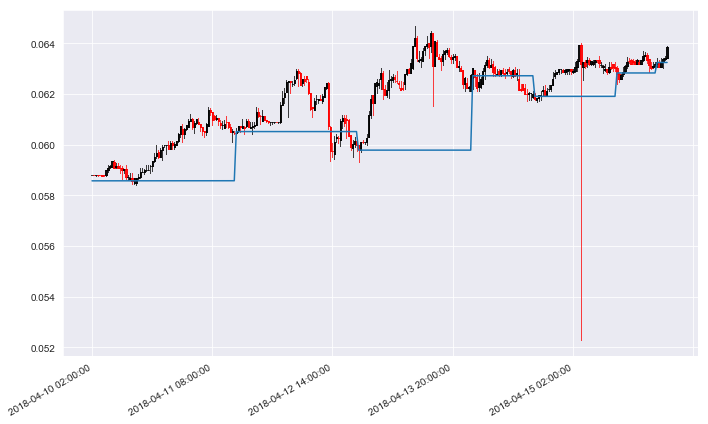

In [54]:
pair = 'BTC_ETH'
data = test_dict[pair]
data['support'] = ohlc_supports_test_dict[pair][12]
data = data.query('date >= "2018-04-10" and date <= "2018-04-16"').reset_index()
plot_candles(data)
plt.plot(data['support'])

In [90]:
def plot_selected_params(selected_params, data_dict, ohlc_supports_dict):
    for i in range(len(selected_params)):
        row = selected_params.iloc[i, :]
        pair = row['pair']
        window_size = row['window_size']
        willing_loss = row['stop_loss']
        _return = row['_return']
        loss_percentage = row['loss_percentage']

        data = data_dict[pair]
        data['support'] = ohlc_supports_dict[pair][window_size]

        strategy = get_strategy(data, pair, willing_loss, _return, loss_percentage)
        print(strategy.stats('btc').report())
        
        print(
            f'wSize = {window_size}',
            f'sLoss = {willing_loss}',
            f'return = {_return}',
            f'loss_percentage = {loss_percentage}',
        )
        df = portfolio_value(strategy, data_dict, pair)
        plot_portfolio_value(df, 1, pair)
        print('-----------------------------------------')

# Select VTC

In [86]:
p_results = results[results['pair'] == 'BTC_VTC']\
    .sort_values('totalProfit', ascending=False)\
    .head(10)
p_results.shape

(10, 23)

10
                    btc
startAmount    100.0000
numberOfTrades 728.0000
totalProfit    968.0235
avgProfit        1.3297
winPercentage   71.5659
avgWinTrade      2.5043
avgLossTrade    -1.6267
profitFactor     3.8748
maxDrawdown      7.1296
avgTimeToClose   5.0546
minTimeToClose   0.2500
maxTimeToClose 127.7500
wSize = 4 sLoss = 0.05 return = -0.01 loss_percentage = 0.2


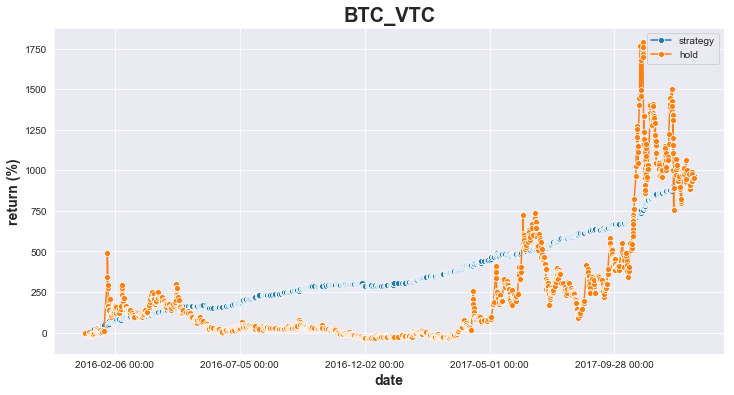

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 733.0000
totalProfit    955.0023
avgProfit        1.3029
winPercentage   70.6685
avgWinTrade      2.5119
avgLossTrade    -1.6099
profitFactor     3.7590
maxDrawdown      6.0768
avgTimeToClose   4.8537
minTimeToClose   0.2500
maxTimeToClose 100.0000
wSize = 4 sLoss = 0.04 return = -0.01 loss_percentage = 0.2


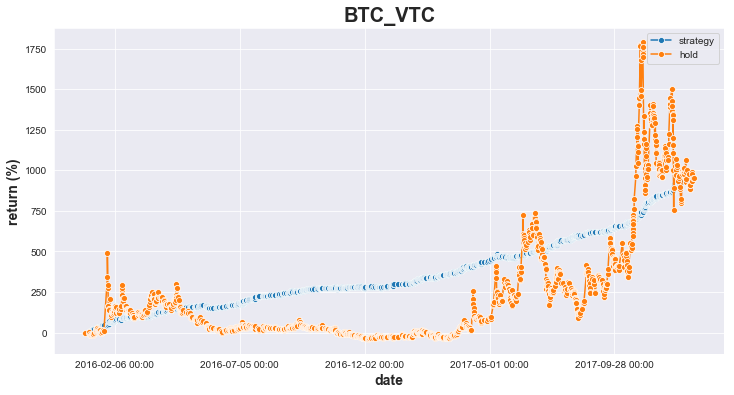

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 728.0000
totalProfit    952.5637
avgProfit        1.3085
winPercentage   67.3077
avgWinTrade      2.6823
avgLossTrade    -1.5199
profitFactor     3.6333
maxDrawdown      7.2142
avgTimeToClose   5.2655
minTimeToClose   0.2500
maxTimeToClose 132.0000
wSize = 4 sLoss = 0.05 return = -0.01 loss_percentage = 0.1


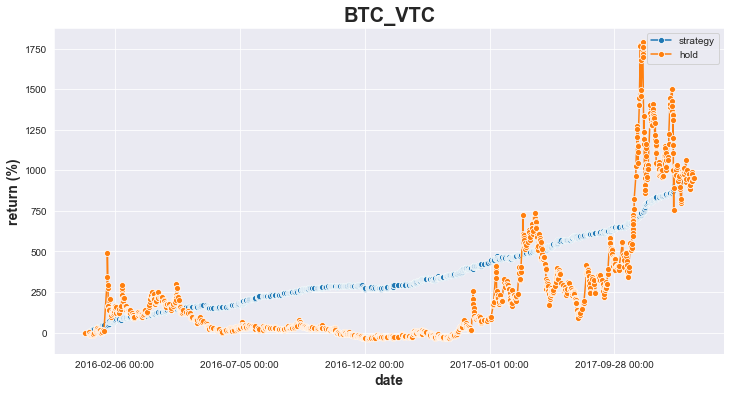

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 731.0000
totalProfit    943.9831
avgProfit        1.2914
winPercentage   83.4473
avgWinTrade      1.9505
avgLossTrade    -2.0314
profitFactor     4.8404
maxDrawdown      6.7774
avgTimeToClose   4.1635
minTimeToClose   0.2500
maxTimeToClose 127.7500
wSize = 4 sLoss = 0.05 return = -0.01 loss_percentage = 1.0


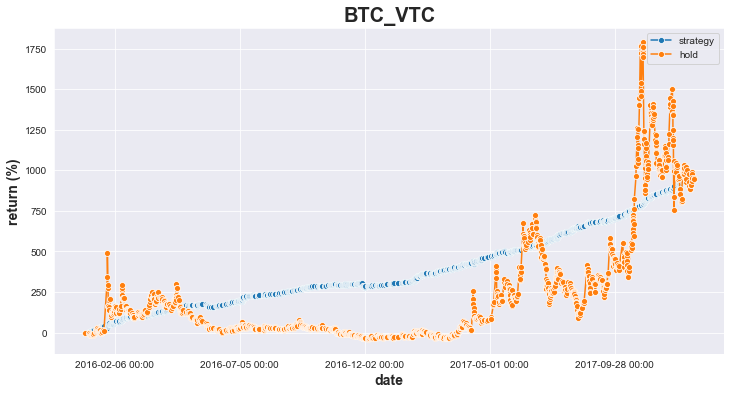

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 729.0000
totalProfit    943.3414
avgProfit        1.2940
winPercentage   73.6626
avgWinTrade      2.3676
avgLossTrade    -1.7086
profitFactor     3.8756
maxDrawdown      7.6169
avgTimeToClose   4.9139
minTimeToClose   0.2500
maxTimeToClose 127.7500
wSize = 4 sLoss = 0.05 return = -0.01 loss_percentage = 0.3


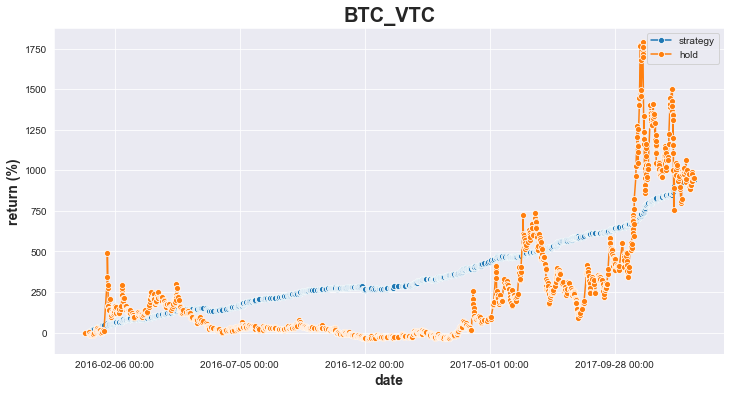

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 733.0000
totalProfit    939.5424
avgProfit        1.2818
winPercentage   66.4393
avgWinTrade      2.6914
avgLossTrade    -1.5087
profitFactor     3.5314
maxDrawdown      6.1497
avgTimeToClose   5.0631
minTimeToClose   0.2500
maxTimeToClose 132.0000
wSize = 4 sLoss = 0.04 return = -0.01 loss_percentage = 0.1


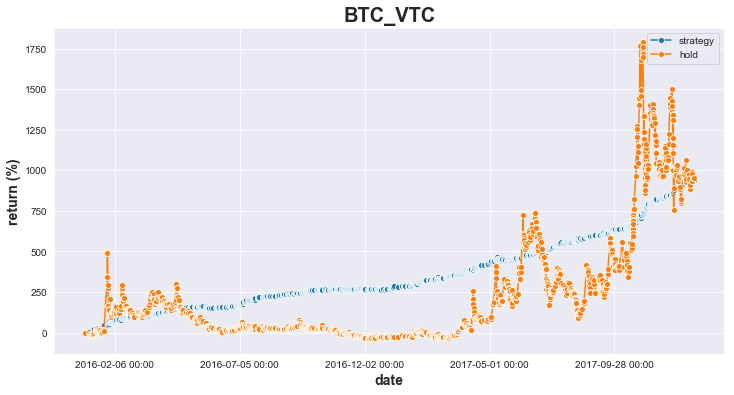

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 731.0000
totalProfit    935.7079
avgProfit        1.2800
winPercentage   79.7538
avgWinTrade      2.0614
avgLossTrade    -1.7980
profitFactor     4.5164
maxDrawdown      6.8978
avgTimeToClose   4.4422
minTimeToClose   0.2500
maxTimeToClose 127.7500
wSize = 4 sLoss = 0.05 return = -0.01 loss_percentage = 0.6


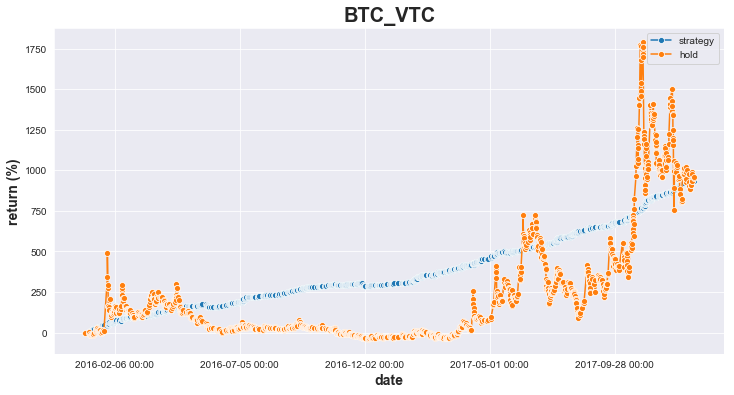

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 736.0000
totalProfit    934.7375
avgProfit        1.2700
winPercentage   82.4728
avgWinTrade      1.9604
avgLossTrade    -1.9784
profitFactor     4.6626
maxDrawdown      6.1934
avgTimeToClose   3.9752
minTimeToClose   0.2500
maxTimeToClose  79.2500
wSize = 4 sLoss = 0.04 return = -0.01 loss_percentage = 1.0


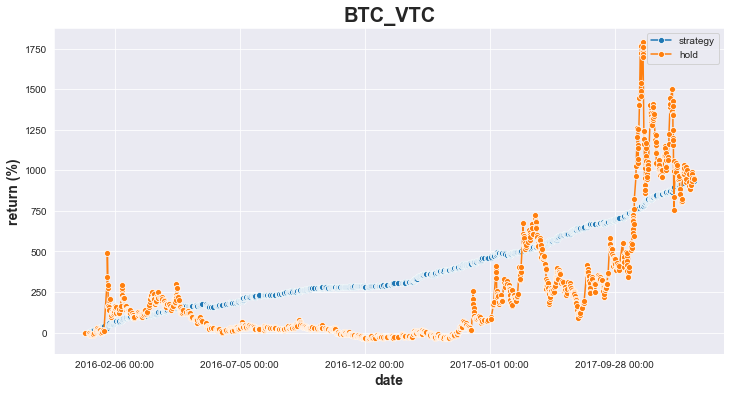

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 731.0000
totalProfit    933.3557
avgProfit        1.2768
winPercentage   82.4897
avgWinTrade      1.9626
avgLossTrade    -1.9539
profitFactor     4.7319
maxDrawdown      6.7774
avgTimeToClose   4.2261
minTimeToClose   0.2500
maxTimeToClose 127.7500
wSize = 4 sLoss = 0.05 return = -0.01 loss_percentage = 0.9


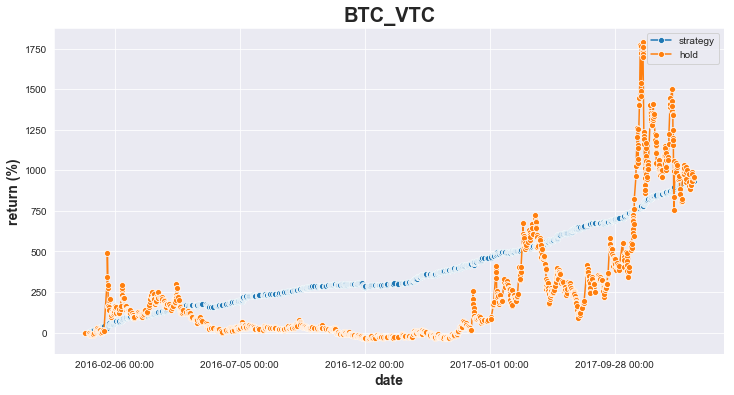

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 731.0000
totalProfit    930.5746
avgProfit        1.2730
winPercentage   77.9754
avgWinTrade      2.1285
avgLossTrade    -1.7557
profitFactor     4.2921
maxDrawdown      7.2691
avgTimeToClose   4.5982
minTimeToClose   0.2500
maxTimeToClose 127.7500
wSize = 4 sLoss = 0.05 return = -0.01 loss_percentage = 0.5


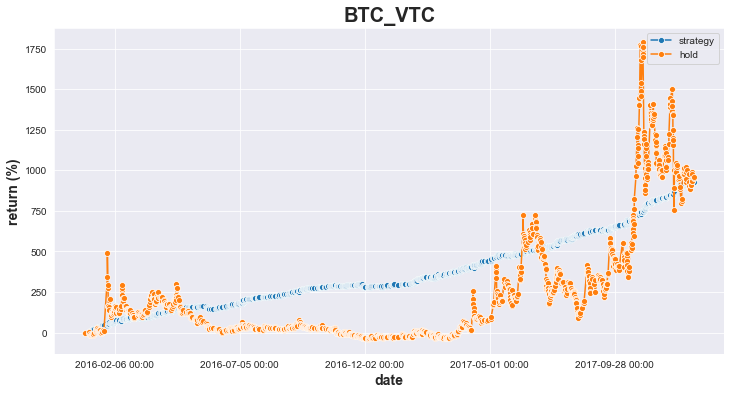

-----------------------------------------


In [87]:
plot_selected_params(p_results, train_dict, ohlc_supports_train_dict)

# Select All

In [88]:
params = results.query('window_size == 4')\
    .query('stop_loss == 0.05')\
    .query('_return == -0.01')\
    .query('loss_percentage == 0.2')

19
                    btc
startAmount    100.0000
numberOfTrades  93.0000
totalProfit      6.8877
avgProfit        0.0741
winPercentage   63.4409
avgWinTrade      1.5668
avgLossTrade    -2.5163
profitFactor     1.0805
maxDrawdown     23.1312
avgTimeToClose  12.3522
minTimeToClose   0.2500
maxTimeToClose 141.0000
wSize = 4.0 sLoss = 0.02 return = -0.02 loss_percentage = 1.0


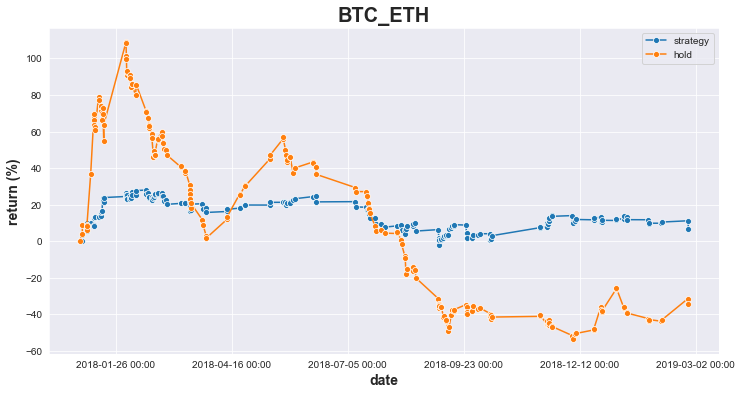

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 252.0000
totalProfit     49.3815
avgProfit        0.1960
winPercentage   69.8413
avgWinTrade      1.2068
avgLossTrade    -2.1449
profitFactor     1.3029
maxDrawdown     12.6302
avgTimeToClose  12.0278
minTimeToClose   0.2500
maxTimeToClose 163.2500
wSize = 4.0 sLoss = 0.02 return = -0.01 loss_percentage = 0.8


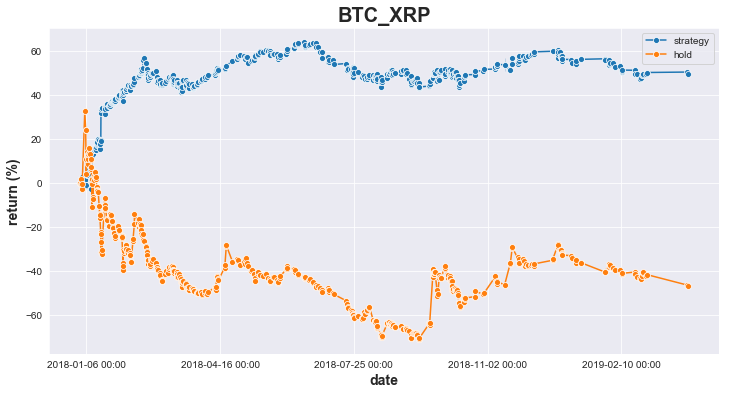

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades  72.0000
totalProfit      4.6373
avgProfit        0.0644
winPercentage   70.8333
avgWinTrade      1.2342
avgLossTrade    -2.7765
profitFactor     1.0795
maxDrawdown     17.0008
avgTimeToClose  21.1146
minTimeToClose   0.2500
maxTimeToClose 235.0000
wSize = 4.0 sLoss = 0.03 return = -0.02 loss_percentage = 0.8


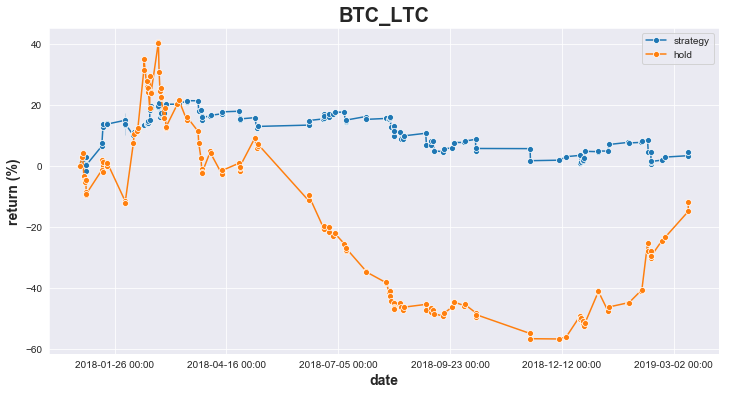

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 193.0000
totalProfit    121.7961
avgProfit        0.6311
winPercentage   89.6373
avgWinTrade      1.0577
avgLossTrade    -3.0589
profitFactor     2.9908
maxDrawdown      9.9954
avgTimeToClose  24.6891
minTimeToClose   0.2500
maxTimeToClose 342.0000
wSize = 6.0 sLoss = 0.05 return = -0.01 loss_percentage = 0.6


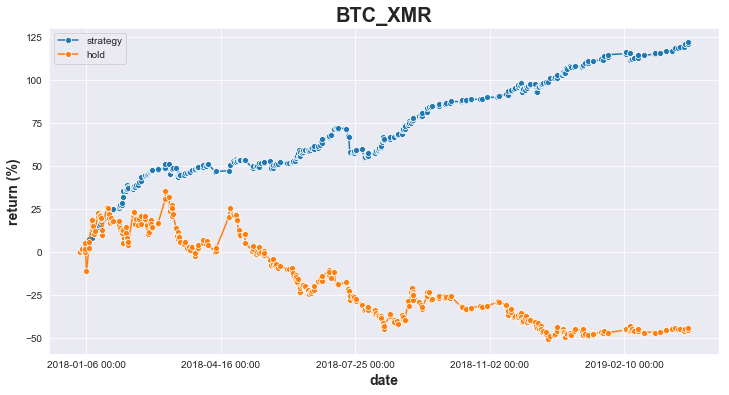

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 326.0000
totalProfit    137.6703
avgProfit        0.4223
winPercentage   75.7669
avgWinTrade      1.2412
avgLossTrade    -2.1381
profitFactor     1.8151
maxDrawdown      6.7697
avgTimeToClose   9.8528
minTimeToClose   0.2500
maxTimeToClose 173.0000
wSize = 4.0 sLoss = 0.02 return = -0.01 loss_percentage = 1.0


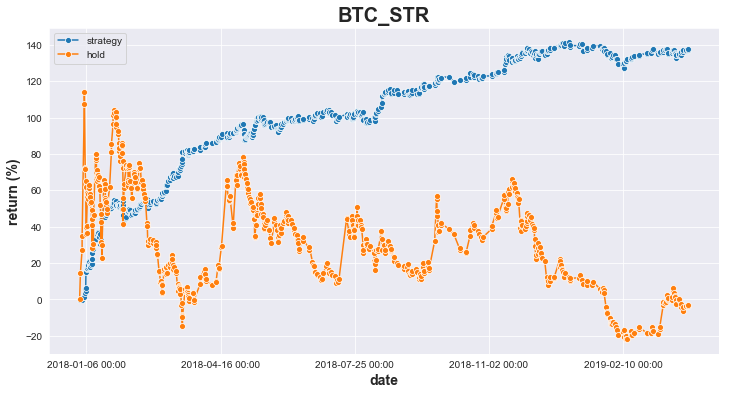

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 291.0000
totalProfit     32.9702
avgProfit        0.1133
winPercentage   71.1340
avgWinTrade      1.1212
avgLossTrade    -2.3705
profitFactor     1.1656
maxDrawdown     38.8731
avgTimeToClose  15.5026
minTimeToClose   0.2500
maxTimeToClose 617.0000
wSize = 4.0 sLoss = 0.02 return = -0.01 loss_percentage = 0.7


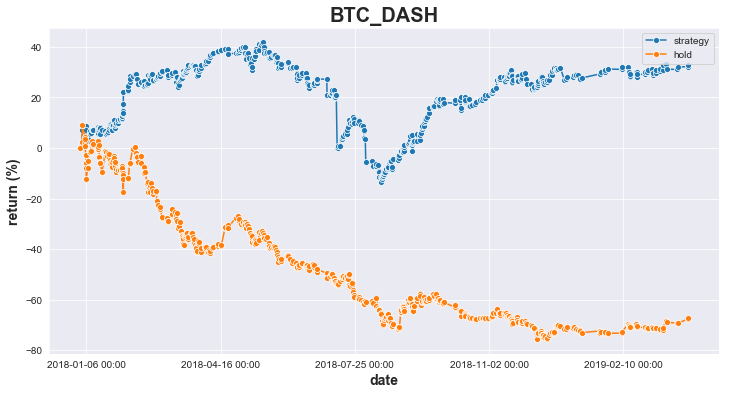

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 251.0000
totalProfit    142.2256
avgProfit        0.5666
winPercentage   79.6813
avgWinTrade      1.3931
avgLossTrade    -2.6745
profitFactor     2.0427
maxDrawdown     10.8761
avgTimeToClose   9.5697
minTimeToClose   0.2500
maxTimeToClose 167.0000
wSize = 6.0 sLoss = 0.02 return = -0.01 loss_percentage = 1.0


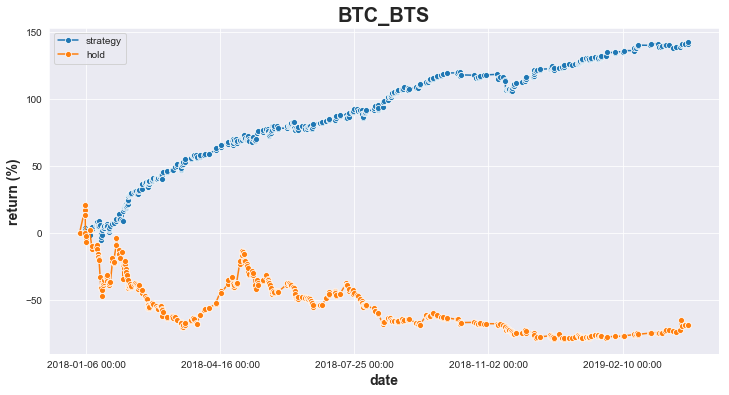

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 385.0000
totalProfit    245.9350
avgProfit        0.6388
winPercentage   77.9221
avgWinTrade      1.3883
avgLossTrade    -2.0066
profitFactor     2.4420
maxDrawdown      8.7245
avgTimeToClose   6.3448
minTimeToClose   0.2500
maxTimeToClose  76.5000
wSize = 4.0 sLoss = 0.02 return = -0.01 loss_percentage = 1.0


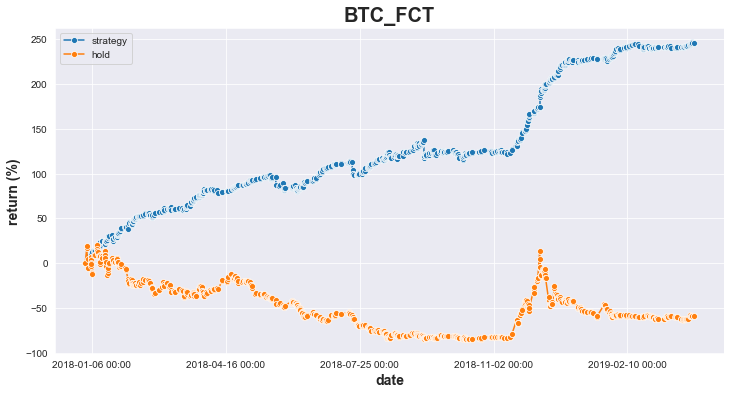

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 283.0000
totalProfit     37.0108
avgProfit        0.1308
winPercentage   68.1979
avgWinTrade      1.2703
avgLossTrade    -2.3128
profitFactor     1.1778
maxDrawdown     15.7159
avgTimeToClose  11.0265
minTimeToClose   0.2500
maxTimeToClose 155.2500
wSize = 4.0 sLoss = 0.02 return = -0.01 loss_percentage = 1.0


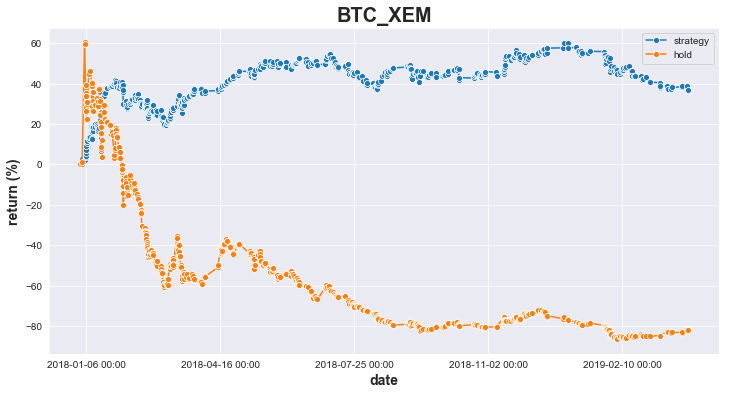

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 301.0000
totalProfit    107.7955
avgProfit        0.3581
winPercentage   69.4352
avgWinTrade      1.2453
avgLossTrade    -1.6573
profitFactor     1.7070
maxDrawdown      6.7103
avgTimeToClose   6.7550
minTimeToClose   0.2500
maxTimeToClose  98.2500
wSize = 4.0 sLoss = 0.01 return = -0.01 loss_percentage = 1.0


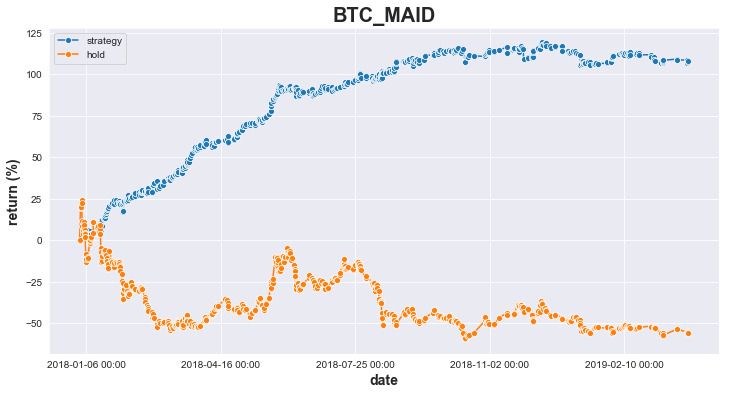

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 155.0000
totalProfit     87.6637
avgProfit        0.5656
winPercentage   81.2903
avgWinTrade      1.3796
avgLossTrade    -2.9711
profitFactor     2.0174
maxDrawdown     10.6940
avgTimeToClose  22.5532
minTimeToClose   0.2500
maxTimeToClose 612.5000
wSize = 8.0 sLoss = 0.05 return = -0.01 loss_percentage = 0.5


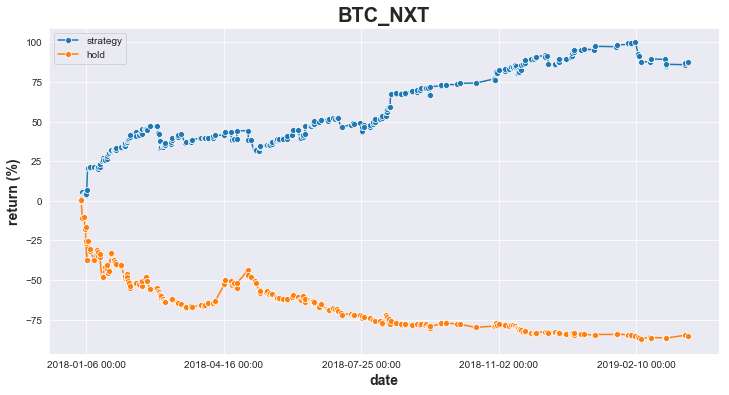

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 250.0000
totalProfit     57.9850
avgProfit        0.2319
winPercentage   79.2000
avgWinTrade      1.3838
avgLossTrade    -4.1540
profitFactor     1.2684
maxDrawdown     25.5141
avgTimeToClose  16.5870
minTimeToClose   0.2500
maxTimeToClose 236.5000
wSize = 4.0 sLoss = 0.05 return = -0.01 loss_percentage = 1.0


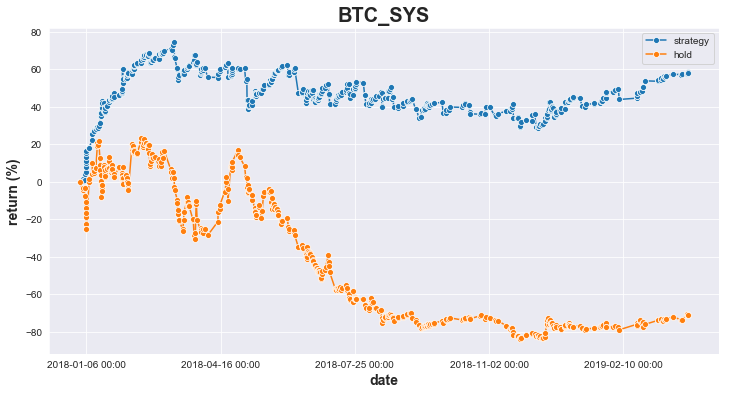

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 339.0000
totalProfit    127.4782
avgProfit        0.3760
winPercentage   76.6962
avgWinTrade      1.3101
avgLossTrade    -2.6979
profitFactor     1.5981
maxDrawdown     25.4819
avgTimeToClose  10.6954
minTimeToClose   0.2500
maxTimeToClose 217.2500
wSize = 4.0 sLoss = 0.05 return = -0.01 loss_percentage = 1.0


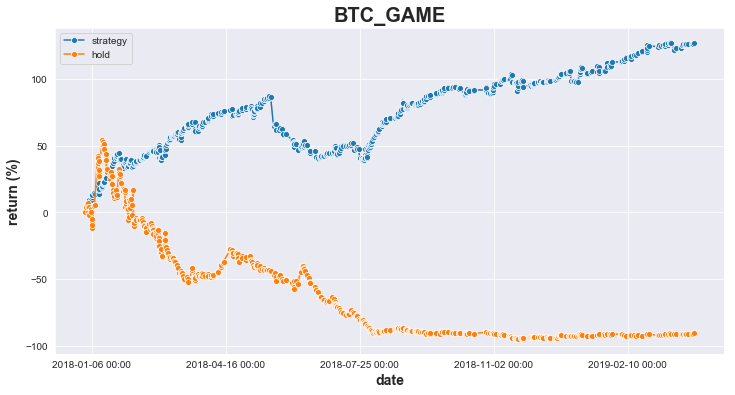

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 191.0000
totalProfit     85.0862
avgProfit        0.4455
winPercentage   80.6283
avgWinTrade      1.3851
avgLossTrade    -3.4652
profitFactor     1.6636
maxDrawdown     28.9439
avgTimeToClose  13.6283
minTimeToClose   0.2500
maxTimeToClose 136.7500
wSize = 6.0 sLoss = 0.05 return = -0.01 loss_percentage = 1.0


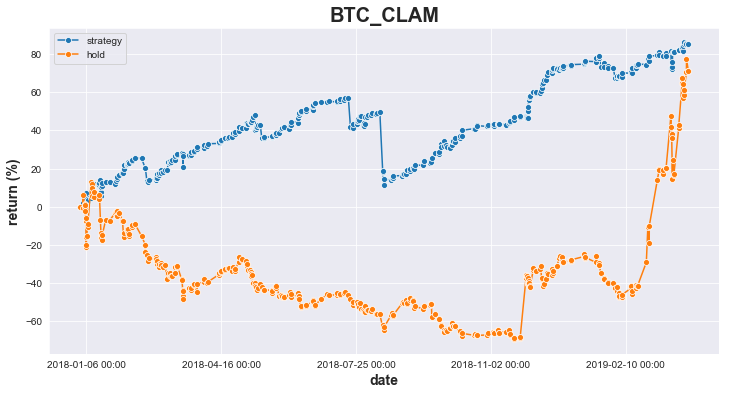

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 293.0000
totalProfit    186.2407
avgProfit        0.6356
winPercentage   79.1809
avgWinTrade      1.3043
avgLossTrade    -1.9075
profitFactor     2.6006
maxDrawdown      8.5457
avgTimeToClose   8.7116
minTimeToClose   0.2500
maxTimeToClose 134.2500
wSize = 4.0 sLoss = 0.05 return = -0.01 loss_percentage = 1.0


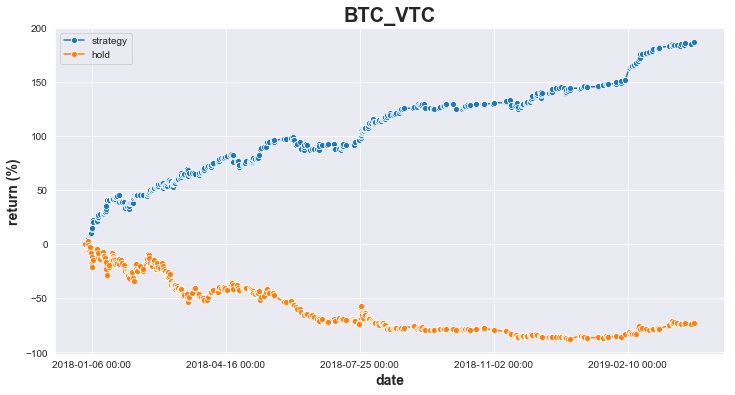

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 253.0000
totalProfit    109.5411
avgProfit        0.4330
winPercentage   77.0751
avgWinTrade      1.4205
avgLossTrade    -2.8873
profitFactor     1.6541
maxDrawdown     26.9904
avgTimeToClose  16.5573
minTimeToClose   0.2500
maxTimeToClose 249.7500
wSize = 4.0 sLoss = 0.05 return = -0.01 loss_percentage = 1.0


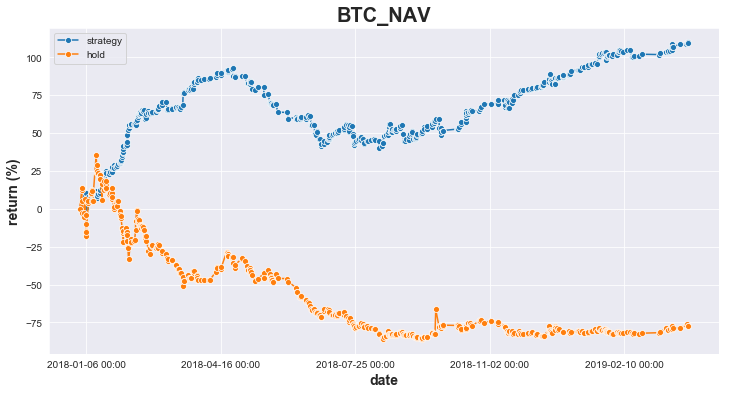

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 221.0000
totalProfit     53.8931
avgProfit        0.2439
winPercentage   76.0181
avgWinTrade      1.5753
avgLossTrade    -3.9767
profitFactor     1.2557
maxDrawdown     24.7386
avgTimeToClose  12.6165
minTimeToClose   0.2500
maxTimeToClose 133.2500
wSize = 6.0 sLoss = 0.05 return = -0.01 loss_percentage = 1.0


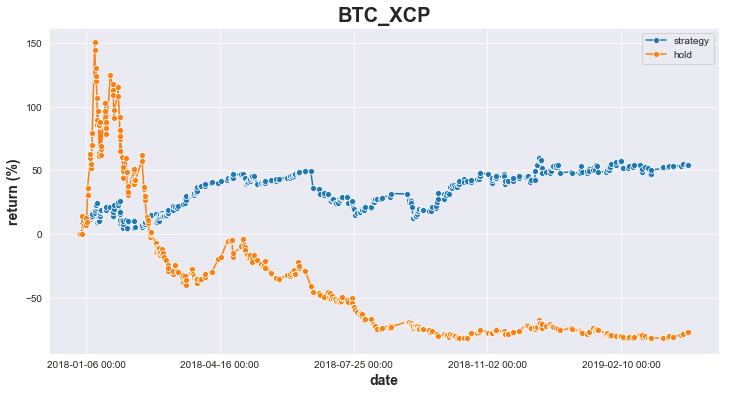

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 166.0000
totalProfit     46.6789
avgProfit        0.2812
winPercentage   73.4940
avgWinTrade      1.5390
avgLossTrade    -3.2064
profitFactor     1.3309
maxDrawdown     22.6581
avgTimeToClose  16.7470
minTimeToClose   0.2500
maxTimeToClose 312.7500
wSize = 8.0 sLoss = 0.03 return = -0.01 loss_percentage = 1.0


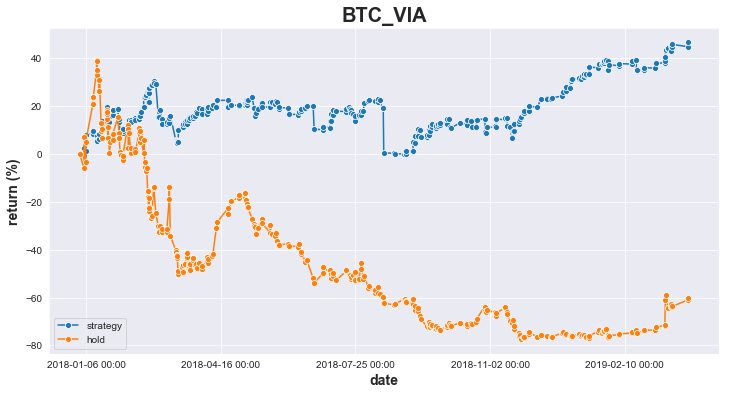

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 308.0000
totalProfit    126.2320
avgProfit        0.4098
winPercentage   73.3766
avgWinTrade      1.2901
avgLossTrade    -2.0162
profitFactor     1.7635
maxDrawdown     14.0906
avgTimeToClose   8.8807
minTimeToClose   0.2500
maxTimeToClose 136.2500
wSize = 4.0 sLoss = 0.04 return = -0.01 loss_percentage = 1.0


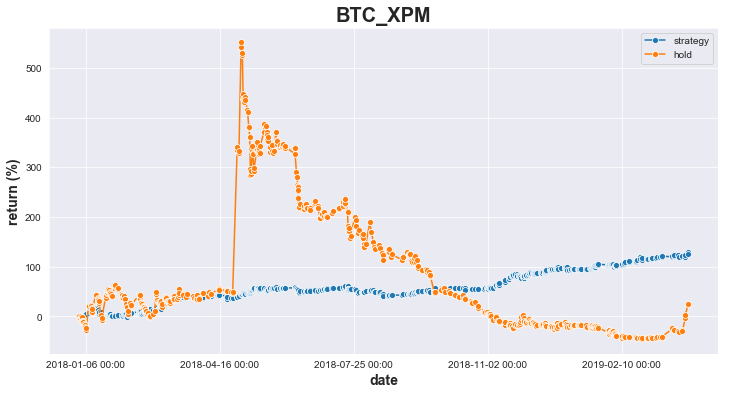

-----------------------------------------


In [89]:
plot_selected_params(selected_params, test_dict, ohlc_supports_test_dict)

                    btc
startAmount    100.0000
numberOfTrades 485.0000
totalProfit    339.7106
avgProfit        0.7004
winPercentage   75.2577
avgWinTrade      1.7341
avgLossTrade    -2.4436
profitFactor     2.1585
maxDrawdown      6.4143
avgTimeToClose   6.9706
minTimeToClose   0.2500
maxTimeToClose 141.0000
wSize = 4.0 sLoss = 0.02 return = -0.02 loss_percentage = 1.0


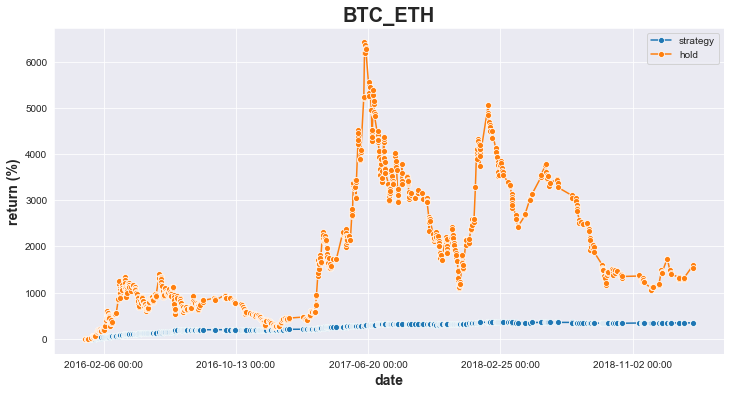

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 880.0000
totalProfit    420.6069
avgProfit        0.4780
winPercentage   73.8636
avgWinTrade      1.4182
avgLossTrade    -2.1791
profitFactor     1.8392
maxDrawdown     12.9353
avgTimeToClose   7.1832
minTimeToClose   0.2500
maxTimeToClose 163.2500
wSize = 4.0 sLoss = 0.02 return = -0.01 loss_percentage = 0.8


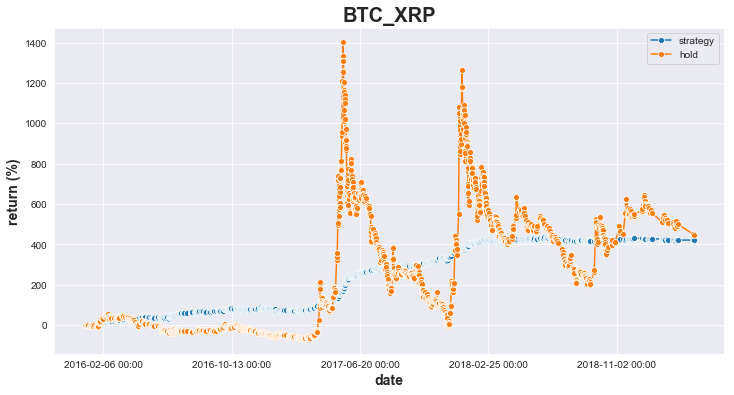

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 255.0000
totalProfit    196.9765
avgProfit        0.7725
winPercentage   79.2157
avgWinTrade      1.6813
avgLossTrade    -2.6913
profitFactor     2.3809
maxDrawdown      7.0218
avgTimeToClose  12.8990
minTimeToClose   0.2500
maxTimeToClose 479.5000
wSize = 4.0 sLoss = 0.03 return = -0.02 loss_percentage = 0.8


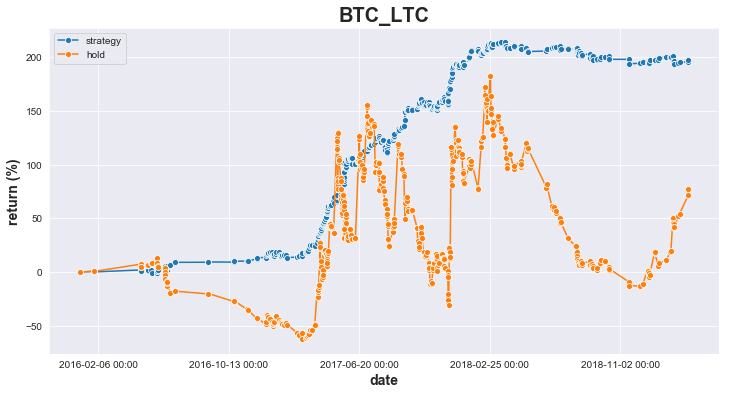

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 678.0000
totalProfit    477.6887
avgProfit        0.7046
winPercentage   82.7434
avgWinTrade      1.3285
avgLossTrade    -2.2870
profitFactor     2.7852
maxDrawdown      9.8934
avgTimeToClose  12.8805
minTimeToClose   0.2500
maxTimeToClose 342.0000
wSize = 6.0 sLoss = 0.05 return = -0.01 loss_percentage = 0.6


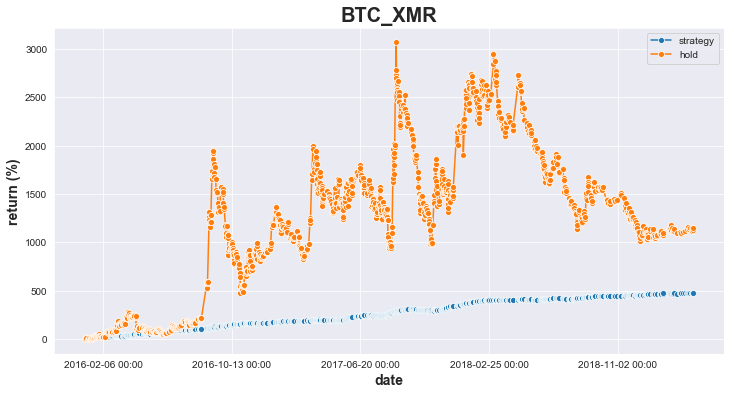

-----------------------------------------
                      btc
startAmount      100.0000
numberOfTrades 1,027.0000
totalProfit      699.1628
avgProfit          0.6808
winPercentage     78.9679
avgWinTrade        1.4602
avgLossTrade      -2.2455
profitFactor       2.4415
maxDrawdown        6.6653
avgTimeToClose     5.5983
minTimeToClose     0.2500
maxTimeToClose   173.0000
wSize = 4.0 sLoss = 0.02 return = -0.01 loss_percentage = 1.0


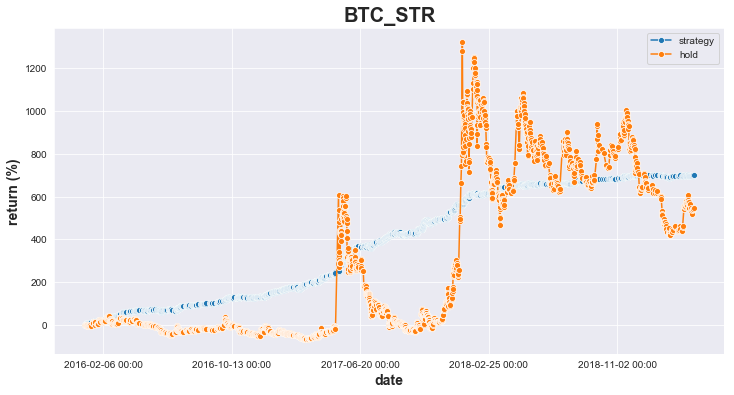

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 960.0000
totalProfit    444.6728
avgProfit        0.4632
winPercentage   75.5208
avgWinTrade      1.2814
avgLossTrade    -2.0611
profitFactor     1.9181
maxDrawdown     10.0021
avgTimeToClose   8.0516
minTimeToClose   0.2500
maxTimeToClose 617.0000
wSize = 4.0 sLoss = 0.02 return = -0.01 loss_percentage = 0.7


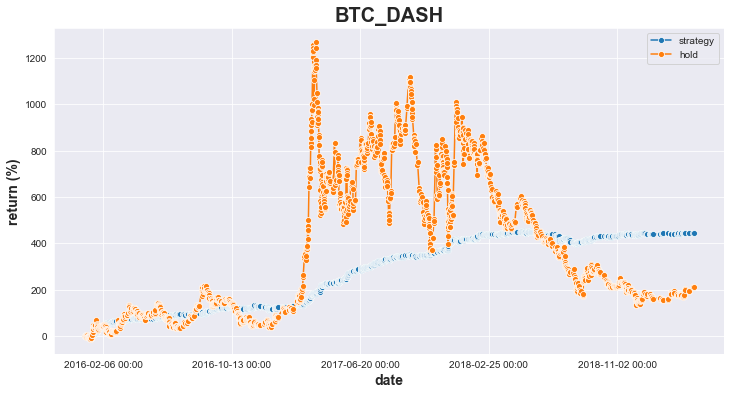

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 772.0000
totalProfit    538.8256
avgProfit        0.6980
winPercentage   78.6269
avgWinTrade      1.5800
avgLossTrade    -2.5470
profitFactor     2.2822
maxDrawdown      6.9636
avgTimeToClose   6.7646
minTimeToClose   0.2500
maxTimeToClose 167.0000
wSize = 6.0 sLoss = 0.02 return = -0.01 loss_percentage = 1.0


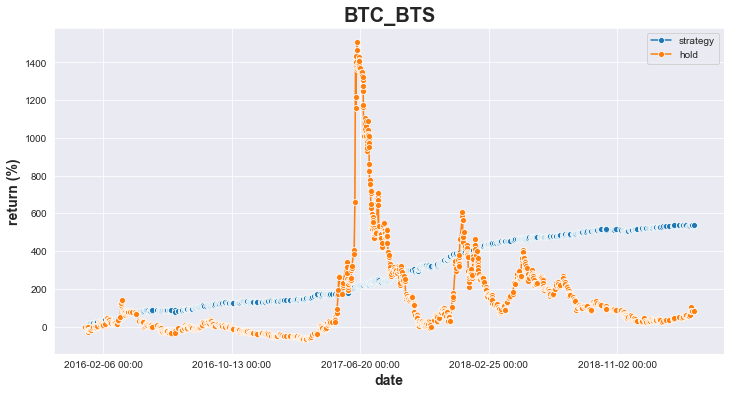

-----------------------------------------
                      btc
startAmount      100.0000
numberOfTrades 1,209.0000
totalProfit      965.1047
avgProfit          0.7983
winPercentage     79.9835
avgWinTrade        1.5728
avgLossTrade      -2.2967
profitFactor       2.7364
maxDrawdown        6.1227
avgTimeToClose     4.5244
minTimeToClose     0.2500
maxTimeToClose    76.5000
wSize = 4.0 sLoss = 0.02 return = -0.01 loss_percentage = 1.0


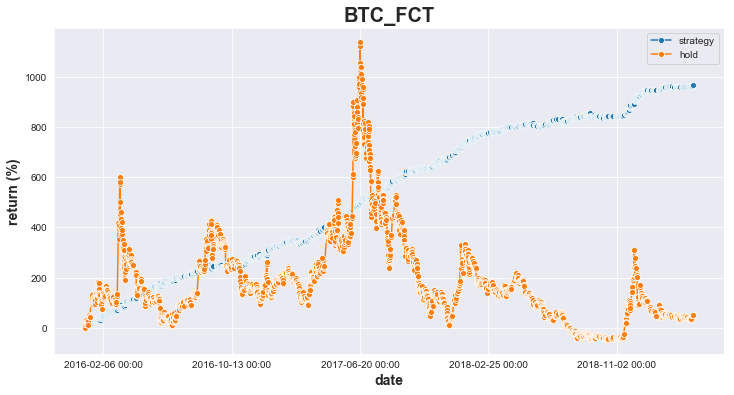

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 968.0000
totalProfit    547.5172
avgProfit        0.5656
winPercentage   74.8967
avgWinTrade      1.5312
avgLossTrade    -2.3153
profitFactor     1.9732
maxDrawdown      8.8005
avgTimeToClose   6.0134
minTimeToClose   0.2500
maxTimeToClose 155.2500
wSize = 4.0 sLoss = 0.02 return = -0.01 loss_percentage = 1.0


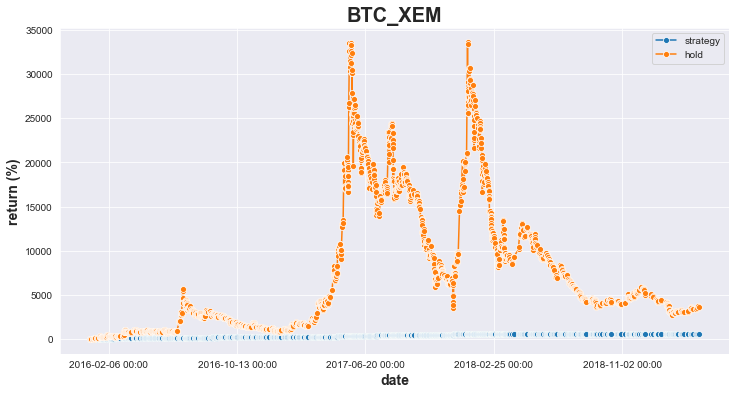

-----------------------------------------
                      btc
startAmount      100.0000
numberOfTrades 1,044.0000
totalProfit      650.2367
avgProfit          0.6228
winPercentage     74.8084
avgWinTrade        1.4379
avgLossTrade      -1.7975
profitFactor       2.3754
maxDrawdown        7.7938
avgTimeToClose     4.3970
minTimeToClose     0.2500
maxTimeToClose    98.2500
wSize = 4.0 sLoss = 0.01 return = -0.01 loss_percentage = 1.0


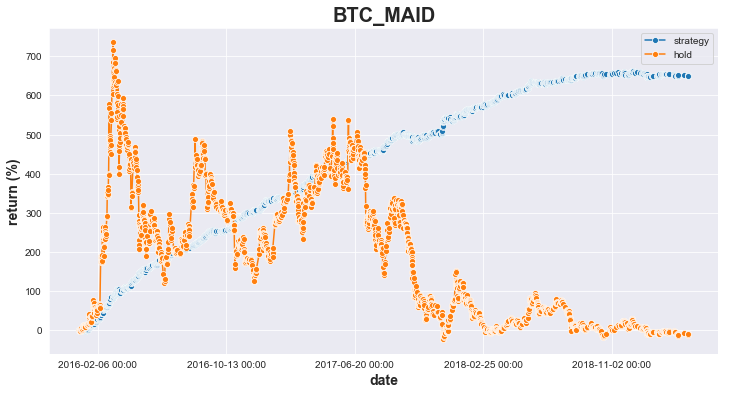

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 514.0000
totalProfit    505.7284
avgProfit        0.9839
winPercentage   78.4047
avgWinTrade      2.0394
avgLossTrade    -2.8484
profitFactor     2.5996
maxDrawdown      8.1916
avgTimeToClose  14.0725
minTimeToClose   0.2500
maxTimeToClose 612.5000
wSize = 8.0 sLoss = 0.05 return = -0.01 loss_percentage = 0.5


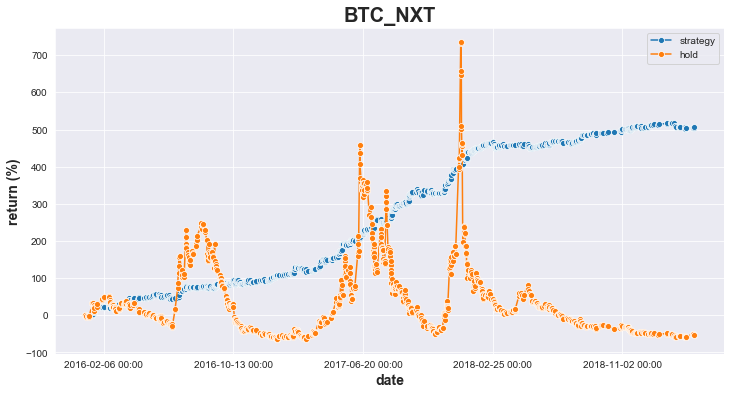

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 940.0000
totalProfit    851.7282
avgProfit        0.9061
winPercentage   82.1277
avgWinTrade      1.8019
avgLossTrade    -3.2106
profitFactor     2.5791
maxDrawdown     16.4854
avgTimeToClose   7.3867
minTimeToClose   0.2500
maxTimeToClose 236.5000
wSize = 4.0 sLoss = 0.05 return = -0.01 loss_percentage = 1.0


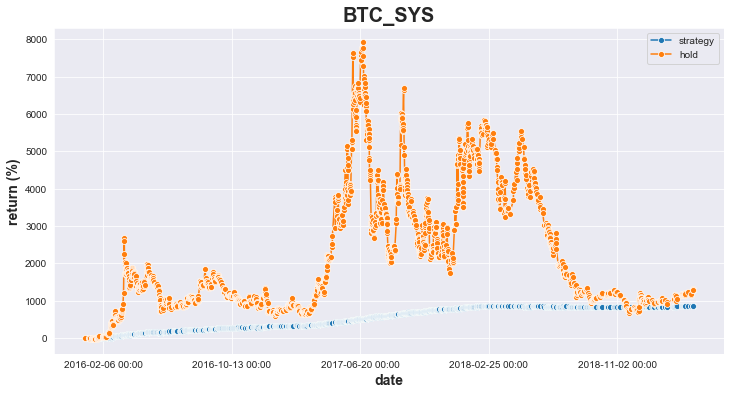

-----------------------------------------
                      btc
startAmount      100.0000
numberOfTrades 1,047.0000
totalProfit      997.8281
avgProfit          0.9530
winPercentage     80.8023
avgWinTrade        1.7821
avgLossTrade      -2.5363
profitFactor       2.9573
maxDrawdown       11.6103
avgTimeToClose     6.4341
minTimeToClose     0.2500
maxTimeToClose   217.2500
wSize = 4.0 sLoss = 0.05 return = -0.01 loss_percentage = 1.0


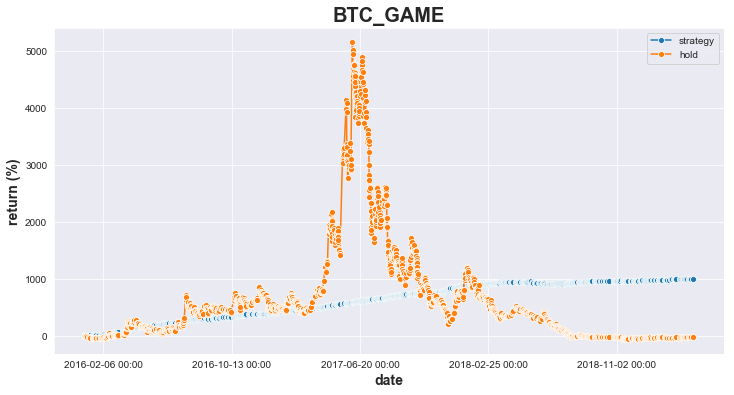

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 632.0000
totalProfit    649.1973
avgProfit        1.0272
winPercentage   81.9620
avgWinTrade      1.8428
avgLossTrade    -2.6787
profitFactor     3.1259
maxDrawdown     21.4091
avgTimeToClose   7.8758
minTimeToClose   0.2500
maxTimeToClose 136.7500
wSize = 6.0 sLoss = 0.05 return = -0.01 loss_percentage = 1.0


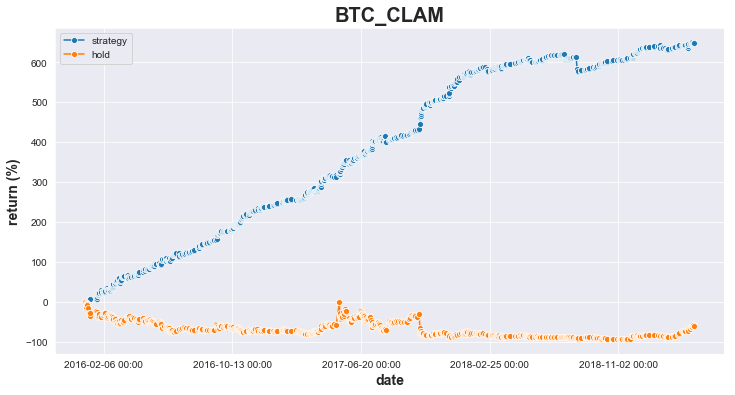

-----------------------------------------
                      btc
startAmount      100.0000
numberOfTrades 1,024.0000
totalProfit    1,130.2238
avgProfit          1.1037
winPercentage     82.2266
avgWinTrade        1.7724
avgLossTrade      -1.9899
profitFactor       4.1208
maxDrawdown        6.7774
avgTimeToClose     5.4648
minTimeToClose     0.2500
maxTimeToClose   134.2500
wSize = 4.0 sLoss = 0.05 return = -0.01 loss_percentage = 1.0


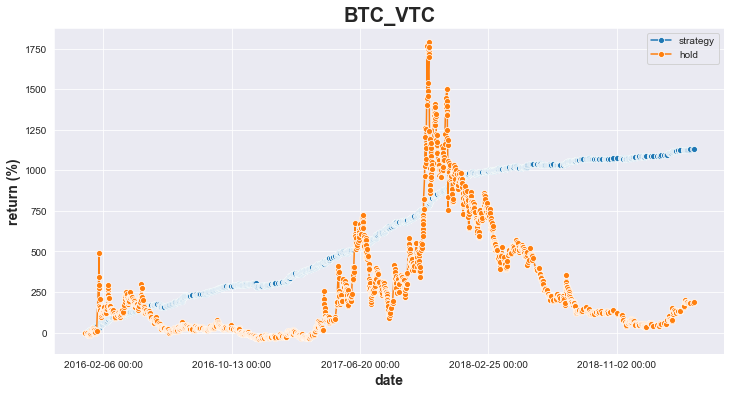

-----------------------------------------
                      btc
startAmount      100.0000
numberOfTrades   899.0000
totalProfit    1,007.6709
avgProfit          1.1209
winPercentage     80.8676
avgWinTrade        2.1677
avgLossTrade      -3.3036
profitFactor       2.7734
maxDrawdown       24.9203
avgTimeToClose     8.1827
minTimeToClose     0.2500
maxTimeToClose   249.7500
wSize = 4.0 sLoss = 0.05 return = -0.01 loss_percentage = 1.0


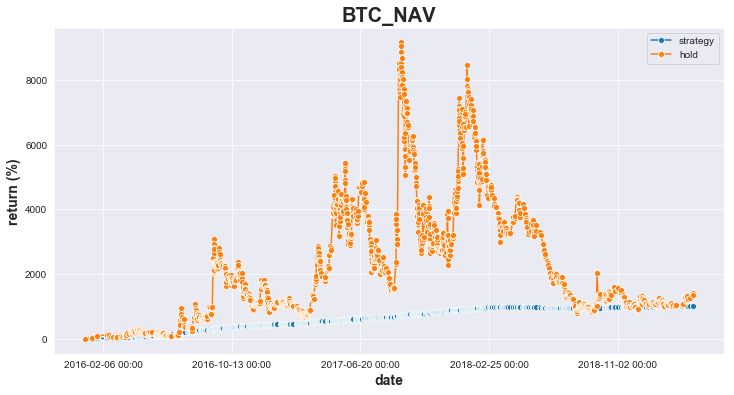

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 697.0000
totalProfit    653.5863
avgProfit        0.9377
winPercentage   80.0574
avgWinTrade      2.0577
avgLossTrade    -3.5582
profitFactor     2.3215
maxDrawdown     10.2666
avgTimeToClose   8.9562
minTimeToClose   0.2500
maxTimeToClose 153.7500
wSize = 6.0 sLoss = 0.05 return = -0.01 loss_percentage = 1.0


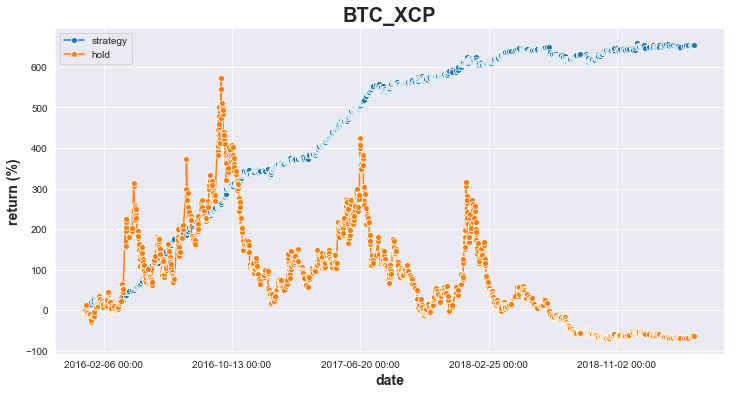

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 514.0000
totalProfit    692.7438
avgProfit        1.3478
winPercentage   81.3230
avgWinTrade      2.3986
avgLossTrade    -3.2277
profitFactor     3.2357
maxDrawdown     17.8891
avgTimeToClose  10.3361
minTimeToClose   0.2500
maxTimeToClose 312.7500
wSize = 8.0 sLoss = 0.03 return = -0.01 loss_percentage = 1.0


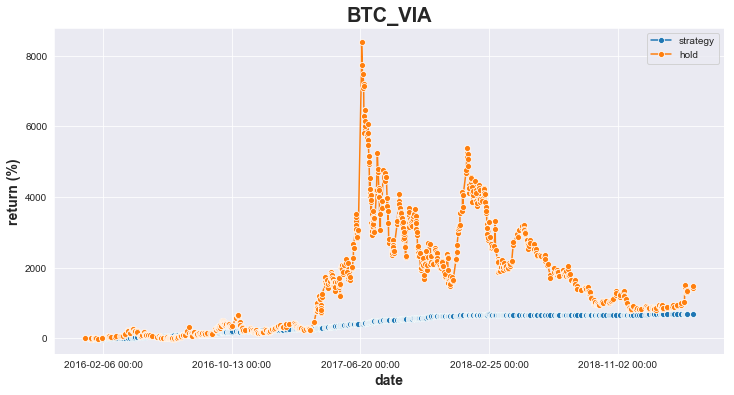

-----------------------------------------
                    btc
startAmount    100.0000
numberOfTrades 878.0000
totalProfit    631.4825
avgProfit        0.7192
winPercentage   75.3986
avgWinTrade      1.6820
avgLossTrade    -2.2314
profitFactor     2.3102
maxDrawdown     16.1816
avgTimeToClose   7.4126
minTimeToClose   0.2500
maxTimeToClose 136.2500
wSize = 4.0 sLoss = 0.04 return = -0.01 loss_percentage = 1.0


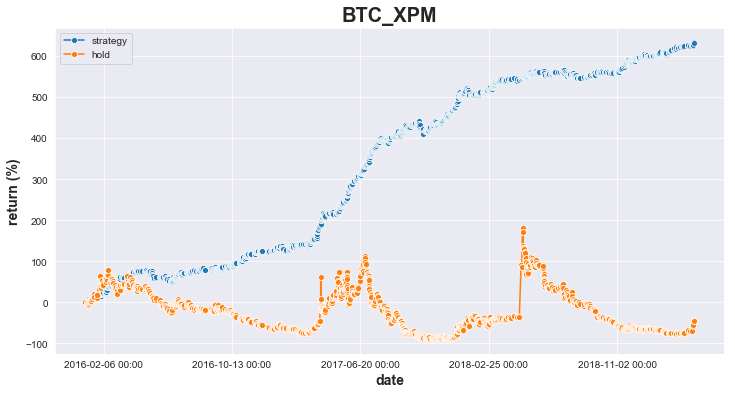

-----------------------------------------


In [91]:
plot_selected_params(selected_params, data_dict, ohlc_supports_dict)